# Project Overview

This project explores and models hourly energy consumption data from [PJM Interconnection LLC](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?utm_source=chatgpt.com)
, a regional transmission organization (RTO) in the United States. The dataset contains hourly electricity consumption values across different regions.

The main objective of this project is to develop a forecasting model that predicts future energy consumption based on historical data.

# Importing Dependencies & Libraries

The following Python libraries were used in this project:

- **Data Handling and Analysis**
  - `pandas` - Data manipulation and analysis
  - `numpy` - Numerical computations
  - ` glob` - File handling for working with multiple datasets

- **Data Visualizations**
  - `matplotlib` - Plotting and visualization
  - `seaborn` - Statistical data visualization with enhanced aesthetics

- **Machine Learning Models**
  - `xgboost.XGBRegressor` - Gradient boosting model for regression tasks
  - `sklearn.liner_model.LinearRegression` - Linear regression baseline model
  - `sklearn.ensemble.RandomForestRegressor` - Ensemble-based regression model

- **Model Evaluation Metrics**
  - `mean_squared_error` - Measures prediction error (sensitive to large error)
  - `mean_absolute_percentage_error` - Percentage-based accuracy metric
  - `r2_score` - Coefficient of determination to assess goodness of fit

In [33]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Importing the Dataset

The original data features various regions on the United States. Each region is in a separate csv file compiled under one folder. Each file has a record of the region's energy consumpion, each record varies in year of collection.

In [ ]:
path = "/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption"

In [ ]:
all_files = glob.glob(path + "/*.csv")

In [ ]:
all_files

['/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/COMED_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/FE_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/DUQ_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/NI_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/DOM_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/AEP_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/EKPC_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/DAYTON_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/DEOK_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hourly_Energy_Consumption/PJME_hourly.csv',
 '/content/drive/MyDrive/Time Series Datasets/PJME_Hou

## Concatenating the CSVs in one dataframe

In [ ]:
dfs = []
for file in all_files:
  df = pd.read_csv(file, parse_dates=['Datetime'])
  consumption_cols = [c for c in df.columns if c.endswith("_MW")][0]
  region = consumption_cols.replace("_MW", "").replace("_Load", "")
  df = df.rename(columns={consumption_cols: 'Consumption'})
  df['Region'] = region
  dfs.append(df)

dataset = pd.concat(dfs, ignore_index=True)

In [ ]:
dataset

,Datetime,Consumption,Region
0,2011-12-31 01:00:00,9970.0,COMED
1,2011-12-31 02:00:00,9428.0,COMED
2,2011-12-31 03:00:00,9059.0,COMED
3,2011-12-31 04:00:00,8817.0,COMED
4,2011-12-31 05:00:00,8743.0,COMED
...,...,...,...
1090162,2018-01-01 20:00:00,8401.0,PJMW
1090163,2018-01-01 21:00:00,8373.0,PJMW
1090164,2018-01-01 22:00:00,8238.0,PJMW
1090165,2018-01-01 23:00:00,7958.0,PJMW


# Dataset Preview

Before diving into preprocessing and modeling, an initial exploration of the dataset was conducted to understand its structure and key characteristics.  
The following checks were performed:

- Dataset **shape** (rows, columns)  
- **Data types** of each column  
- List of available **regions**  
- **Datetime range** covered in the dataset  
- Count of **missing values** per column  

These quick inspections help verify data consistency, understand coverage, and highlight any potential data quality issues (such as missing or incorrect values) that need to be addressed during preprocessing.


In [ ]:
print(f'Dataset has {dataset.shape[0]} rows and  {dataset.shape[1]} columns.')

Dataset has 1090167 rows and  3 columns.


In [ ]:
pd.DataFrame(dataset.dtypes, columns=['Data Type']).reset_index().rename(columns={"index":"Column"})

,Column,Data Type
0,Datetime,datetime64[ns]
1,Consumption,float64
2,Region,object


In [34]:
dataset['Region'].unique()

array(['COMED', 'FE', 'DUQ', 'NI', 'DOM', 'AEP', 'EKPC', 'DAYTON', 'DEOK',
       'PJME', 'PJM', 'PJMW'], dtype=object)

In [ ]:
print(f'Min. Date: {dataset['Datetime'].min().strftime('%Y-%m-%d')} \nMax. Date: {dataset['Datetime'].max().strftime('%Y-%m-%d')} \nDate Range: {dataset['Datetime'].max()- dataset['Datetime'].min()}')

Min. Date: 1998-04-01 
Max. Date: 2018-08-03 
Date Range: 7428 days 23:00:00


In [ ]:
pd.DataFrame(dataset.isna().sum(), columns=['Missing Values']).reset_index().rename(columns={"index":"Column"})

,Column,Missing Values
0,Datetime,0
1,Consumption,0
2,Region,0


# Exploratory Data Analysis (EDA)

To better understand the dataset and uncover underlying patterns, an exploratory analysis was performed focusing on three key aspects:

- **Trends Over Time**  
  Examined the overall electricity consumption patterns across the available time span to identify long-term increases, decreases, or shifts in demand.

- **Seasonality**  
  Investigated recurring patterns such as daily, weekly, and yearly cycles that commonly influence energy usage (e.g., higher demand during peak hours, weekdays vs weekends, or seasonal weather impacts).

- **Regional Comparison**  
  Compared consumption across different regions within the dataset to highlight geographic differences in demand levels and usage behaviors.


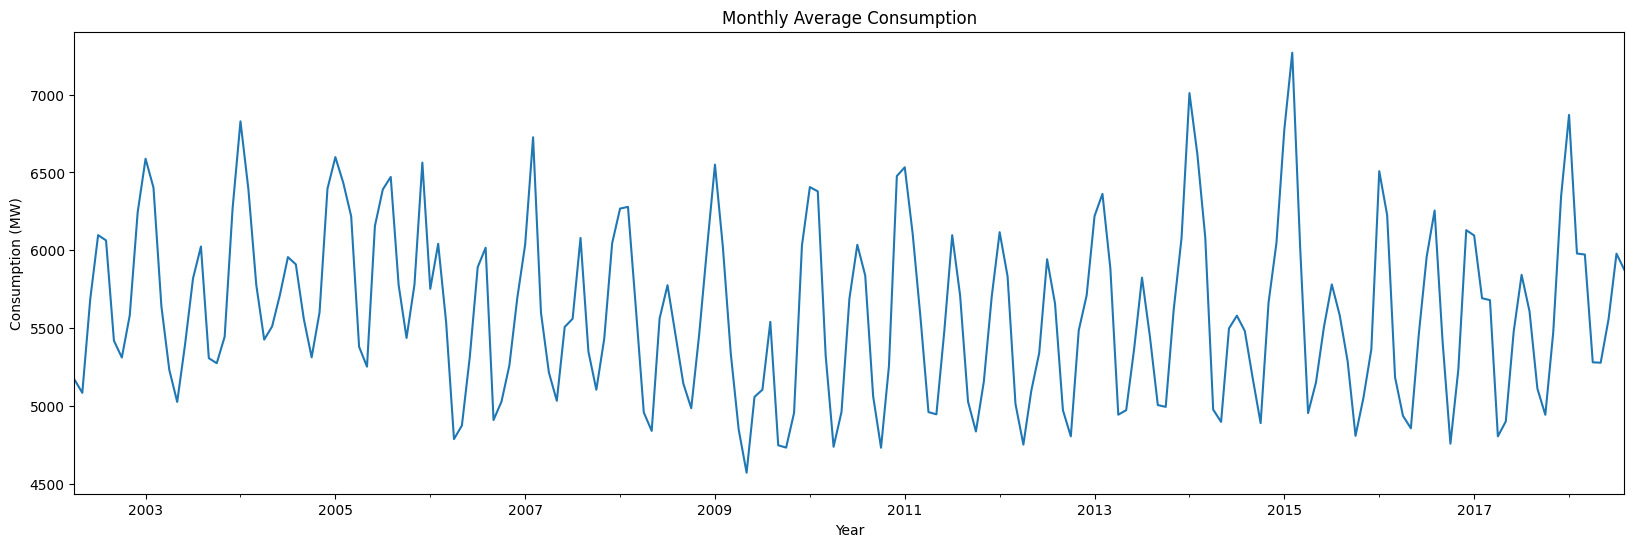

In [36]:
region_data = dataset[dataset['Region'] == region]
region_data.set_index('Datetime')['Consumption'].resample("ME").mean().plot(figsize=(20,6))
plt.title(f"Monthly Average Consumption")
plt.ylabel("Consumption (MW)")
plt.xlabel("Year")
plt.show()

In [ ]:
dataset['hour'] = dataset['Datetime'].dt.hour
dataset['day'] = dataset['Datetime'].dt.day
dataset['dayofweek'] = dataset['Datetime'].dt.dayofweek
dataset['month'] = dataset['Datetime'].dt.month

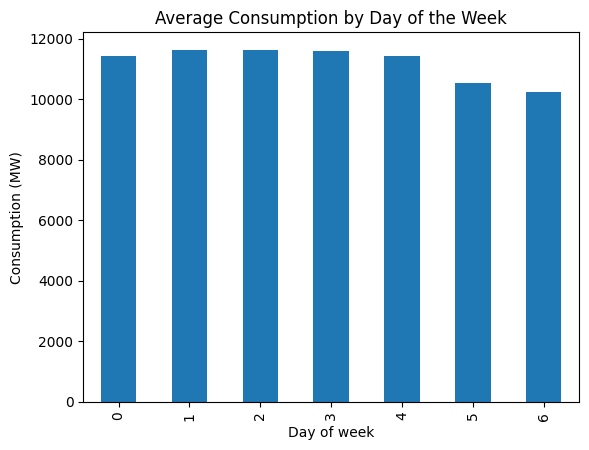

In [39]:
dataset.groupby('dayofweek')['Consumption'].mean().plot(kind='bar')
plt.title("Average Consumption by Day of the Week")
plt.ylabel("Consumption (MW)")
plt.xlabel("Day of week")
plt.show()

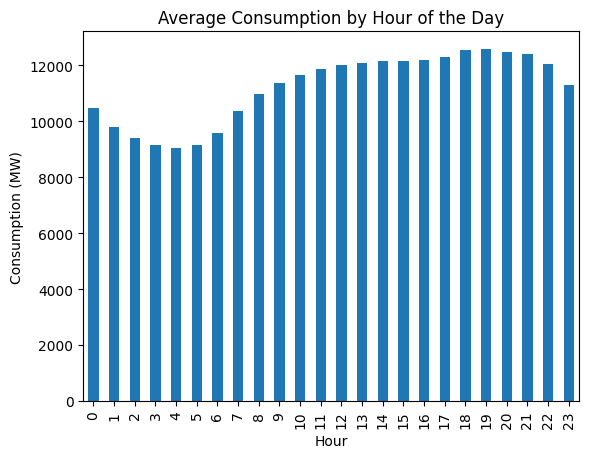

In [ ]:
dataset.groupby('hour')['Consumption'].mean().plot(kind='bar')
plt.title("Average Consumption by Hour of the Day")
plt.ylabel("Consumption (MW)")
plt.xlabel("Hour")
plt.show()

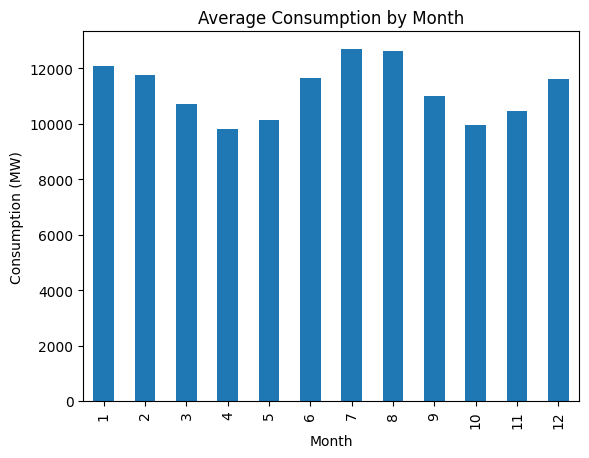

In [38]:
dataset.groupby('month')['Consumption'].mean().plot(kind='bar')
plt.title("Average Consumption by Month")
plt.ylabel("Consumption (MW)")
plt.xlabel("Month")
plt.show()

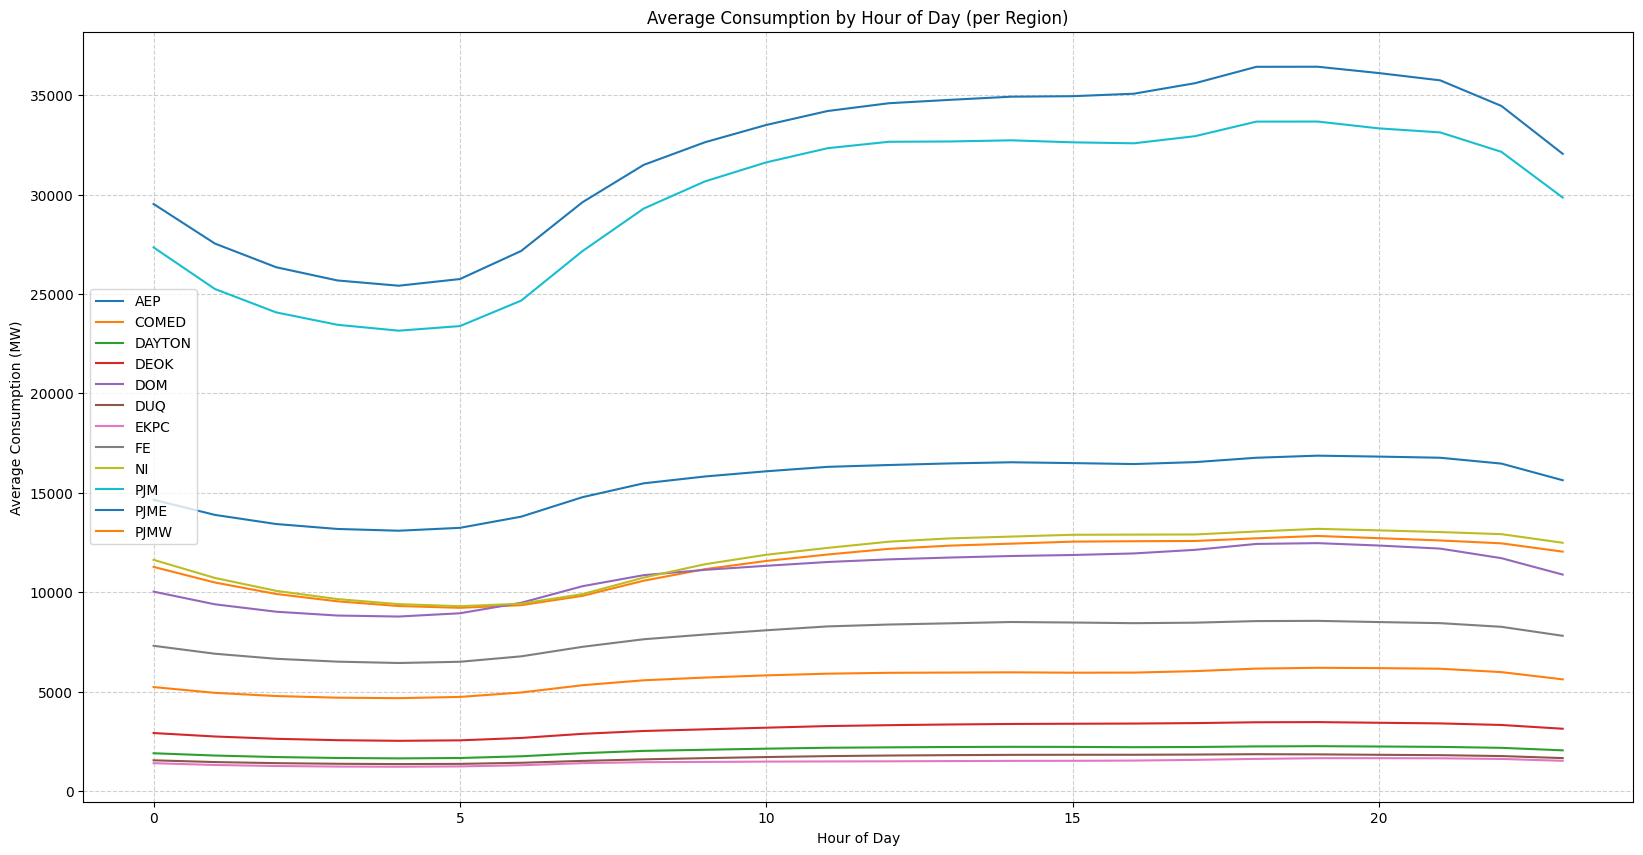

In [35]:
avg_hourly = dataset.groupby(['Region', 'hour'])['Consumption'].mean().reset_index()
plt.figure(figsize=(20,10))

for region in avg_hourly['Region'].unique():
    region_data = avg_hourly[avg_hourly['Region'] == region]
    plt.plot(region_data['hour'], region_data['Consumption'], label=region)

plt.title("Average Consumption by Hour of Day (per Region)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Consumption (MW)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

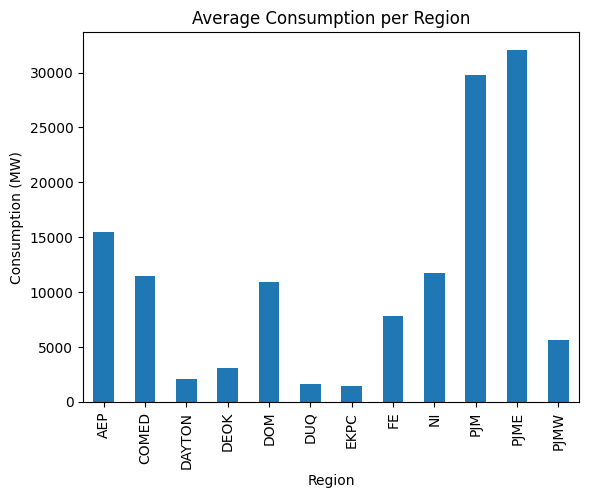

In [ ]:
dataset.groupby('Region')['Consumption'].mean().plot(kind='bar')
plt.title("Average Consumption per Region")
plt.ylabel("Consumption (MW)")
plt.show()

# Data Processing

To prepare the dataset for forecasting, the following preprocessing steps were applied:

- **Lag Features**  
  - Created lagged variables at:  
    - `t-1` (previous hour)  
    - `t-24` (previous day)  
    - `t-168` (previous week)  
  - These features help the model capture short-term, daily, and weekly dependencies in electricity consumption.

- **Rolling Statistics**  
  - Computed rolling averages to smooth fluctuations and capture broader consumption patterns:  
    - 24-hour rolling mean (daily trends)  
    - 7-day rolling mean (weekly trends)

- **Missing Value Handling**  
  - Dropped rows with `NaN` values created during lag and rolling feature generation.

- **Data Splitting**  
  - Split the dataset into training and testing sets to evaluate model performance on unseen data.  
  - This ensures the forecasting models are validated on future time periods rather than random samples.

In [ ]:
for lag in [1, 24, 168]:
    dataset[f'lag_{lag}'] = dataset.groupby('Region')['Consumption'].shift(lag)

In [ ]:
dataset['rolling_24h'] = dataset.groupby('Region')['Consumption'].shift(1).rolling(24).mean()
dataset['rolling_7d'] = dataset.groupby('Region')['Consumption'].shift(1).rolling(24*7).mean()

In [ ]:
dataset = dataset.dropna()

In [ ]:
train_size = int(len(dataset) * 0.8)
train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]

# Model Training (XGBoost)

The first forecasting model applied was **XGBoost Regressor**, a gradient boosting algorithm well-suited for handling structured time series data with engineered features.

- **Why XGBoost?**  
  - Handles non-linear relationships effectively  
  - Robust to outliers and missing values  
  - Efficient with large datasets  
  - Built-in regularization to reduce overfitting  

- **Training Setup**  
  - Used lag and rolling features as predictors  
  - Trained on the historical portion of the dataset  
  - Evaluated predictions on the test split  

This initial experiment served as a benchmark for comparing model performance against other approaches.




In [ ]:
features = ['lag_1', 'lag_24', 'rolling_24h', 'hour', 'dayofweek', 'month']
X_train, y_train = train[features], train['Consumption']
X_test, y_test = test[features], test['Consumption']

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Model Evaluation (XGBoost)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAPE:", mape)

RMSE: 479.0671389291363
MAPE: 0.03533780506596668


The XGBoost model was evaluated using common regression metrics to assess forecasting accuracy:

- **Root Mean Squared Error (RMSE):** `479.07`  
  - Indicates the average magnitude of prediction errors.  
  - Lower values suggest better performance.  

- **Mean Absolute Percentage Error (MAPE):** `3.53%`  
  - Shows that on average, the model’s predictions were within a small percentage of the actual values.  


## Model Prediction vs Actual

We test the trained model if it is capable of forecasting accurately.

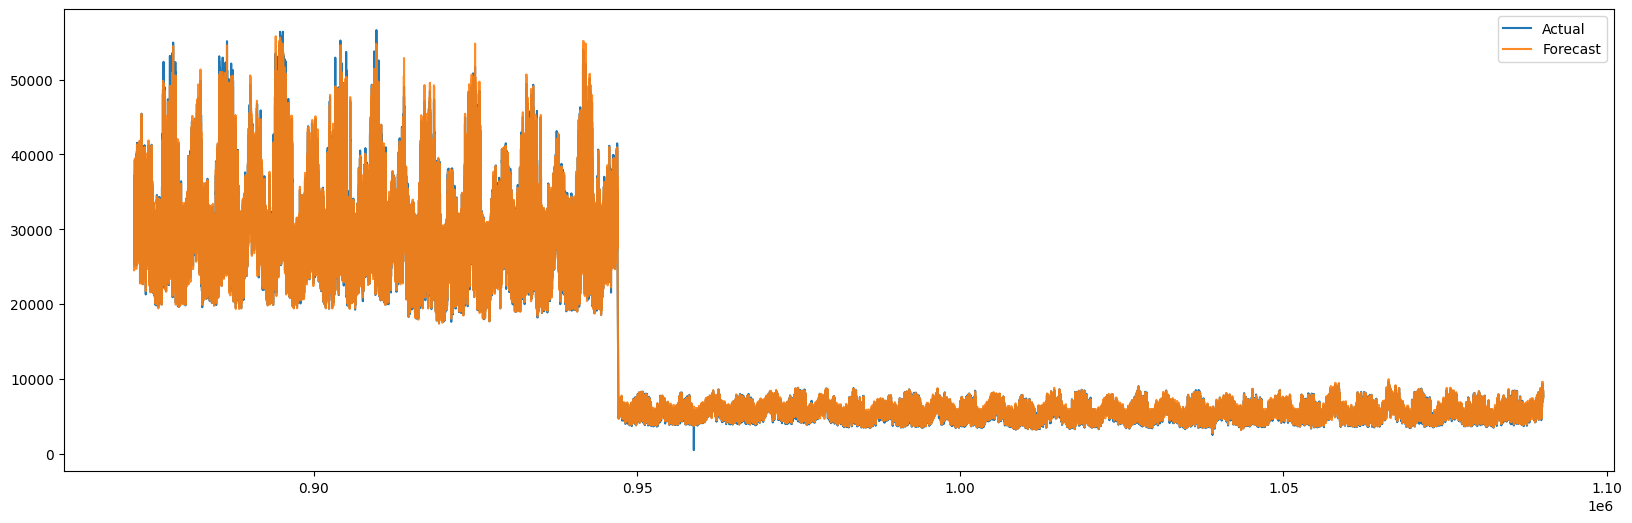

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(test.index, y_test, label="Actual")
plt.plot(test.index, y_pred, label="Forecast", alpha=0.9)
plt.legend()
plt.show()

## Reviewing Model Error rate

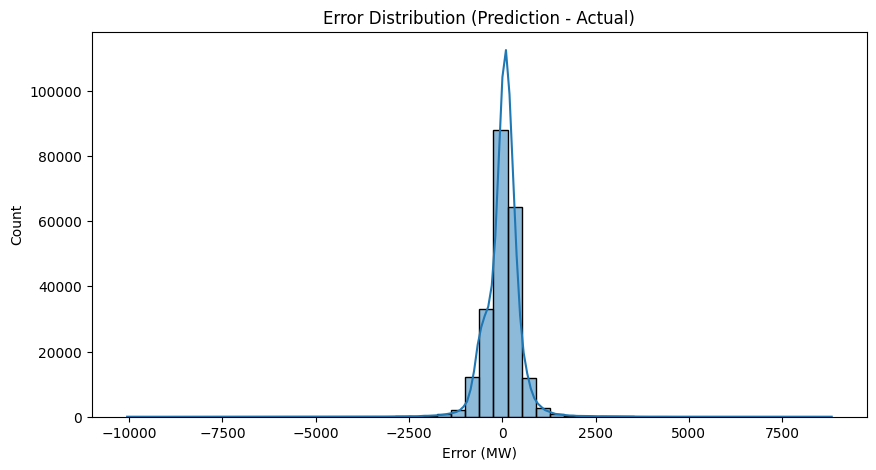

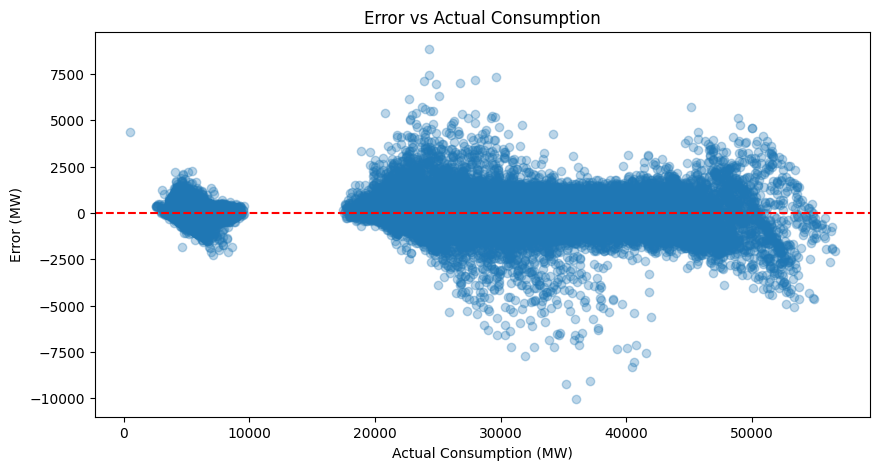

In [ ]:
results = test.copy()
results['Prediction'] = y_pred
results['Error'] = results['Prediction'] - results['Consumption']
results['AbsoluteError'] = results['Error'].abs()

plt.figure(figsize=(10,5))
sns.histplot(results['Error'], bins=50, kde=True)
plt.title("Error Distribution (Prediction - Actual)")
plt.xlabel("Error (MW)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(results['Consumption'], results['Error'], alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Error vs Actual Consumption")
plt.xlabel("Actual Consumption (MW)")
plt.ylabel("Error (MW)")
plt.show()

## Forecasting Region Consumption

We try and forecast a region consumption using the trained model. We test if the model trained for general use is capable of forecasting specific region/s.

In [ ]:
region_metrics = []

for region, group in results.groupby('Region'):
    rmse = np.sqrt(mean_squared_error(group['Consumption'], group['Prediction']))
    mape = mean_absolute_percentage_error(group['Consumption'], group['Prediction'])
    region_metrics.append({'Region': region, 'RMSE': rmse, 'MAPE': mape})

region_df = pd.DataFrame(region_metrics)
print(region_df)

  Region        RMSE      MAPE
0    PJM  635.674162  0.015131
1   PJME  730.733007  0.015165
2   PJMW  316.936688  0.045865


In [ ]:
region_name = "PJM"
region_data = dataset[dataset['Region'] == region_name]
feature_columns = ['lag_1', 'lag_24', 'rolling_24h', 'hour', 'dayofweek', 'month']
X_region = region_data[feature_columns]
y_region_pred = model.predict(X_region)

region_data['Prediction'] = y_region_pred

/tmp/ipython-input-228735674.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data['Prediction'] = y_region_pred


<Axes: xlabel='Datetime'>

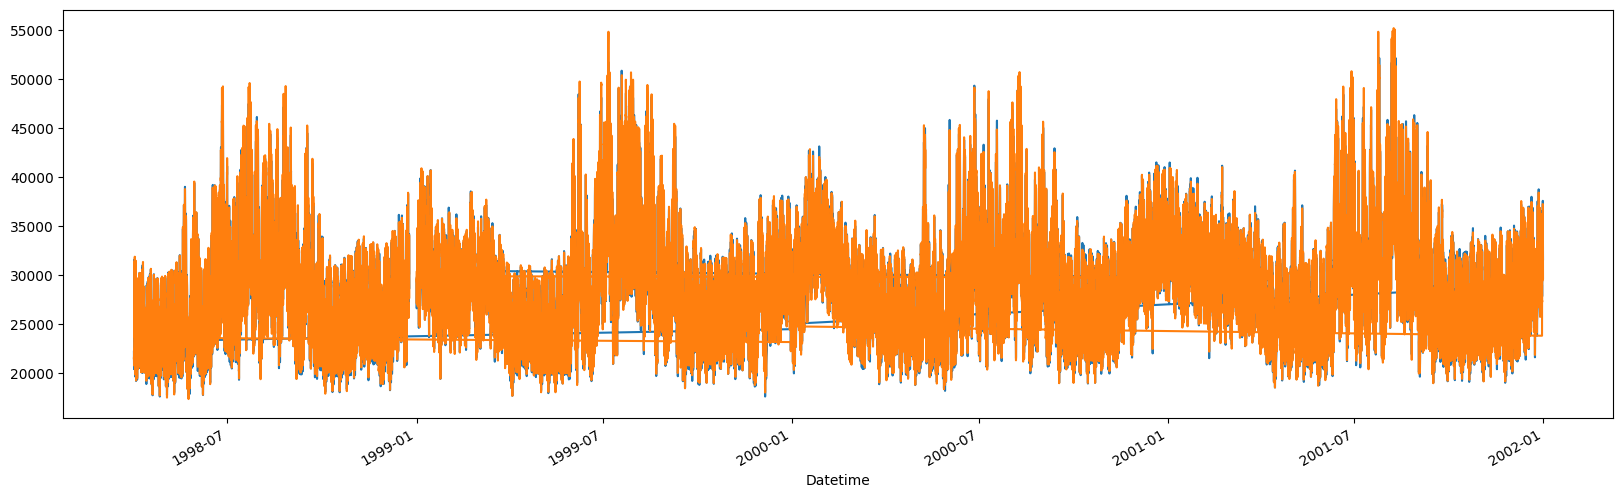

In [ ]:
region_data.set_index('Datetime')['Consumption'].plot(figsize=(20,6))
region_data.set_index('Datetime')['Prediction'].plot(figsize=(20,6))

## Model Benchmarking

To assess whether XGBoost provided the best performance, the dataset was also trained and evaluated on additional models:

- **Linear Regression** (baseline)  
- **Random Forest Regressor**  
- **XGBoost Regressor** (tuned with 300 estimators, learning rate = 0.1)

Each model was evaluated on the same train/test split using the following metrics:
- **RMSE** → Measures error magnitude  
- **MAPE** → Measures relative accuracy  
- **R²** → Indicates how well the model explains variance in the data  

A comparison table was created to benchmark performance across models:

| Model              | RMSE      | MAPE   | R²   |
|--------------------|-----------|--------|------|
| Linear Regression  | 822.27    | 3.11%  | 0.995656  |
| Random Forest      | 420.95    | 2.66%  | 0.998861  |
| XGBoost            | 466.15    | 3.34%  | 0.998604  |

*(Values shown here are placeholders — filled with actual results from training)*  

This benchmarking process highlights the trade-offs between simple interpretable models and more complex ensemble methods.


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
}

results = []
fitted_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "RMSE": rmse, "MAPE": mape, "R²": r2})

import pandas as pd
benchmark = pd.DataFrame(results)
print(benchmark)

               Model        RMSE      MAPE        R²
0  Linear Regression  822.273128  0.031136  0.995656
1      Random Forest  420.954610  0.026591  0.998861
2            XGBoost  466.151566  0.033445  0.998604


## Testing Random Forest

We test the forecasting capability of the better trained model, Random Forest using the same region.

In [31]:
rf_model = fitted_models["Random Forest"]

region_name = "PJM"
region_data = dataset[dataset['Region'] == region_name]
feature_columns = ['lag_1', 'lag_24', 'rolling_24h', 'hour', 'dayofweek', 'month']
X_region = region_data[feature_columns]
y_region_pred = rf_model.predict(X_region)

region_data['Prediction'] = y_region_pred

/tmp/ipython-input-1693326639.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data['Prediction'] = y_region_pred


<Axes: xlabel='Datetime'>

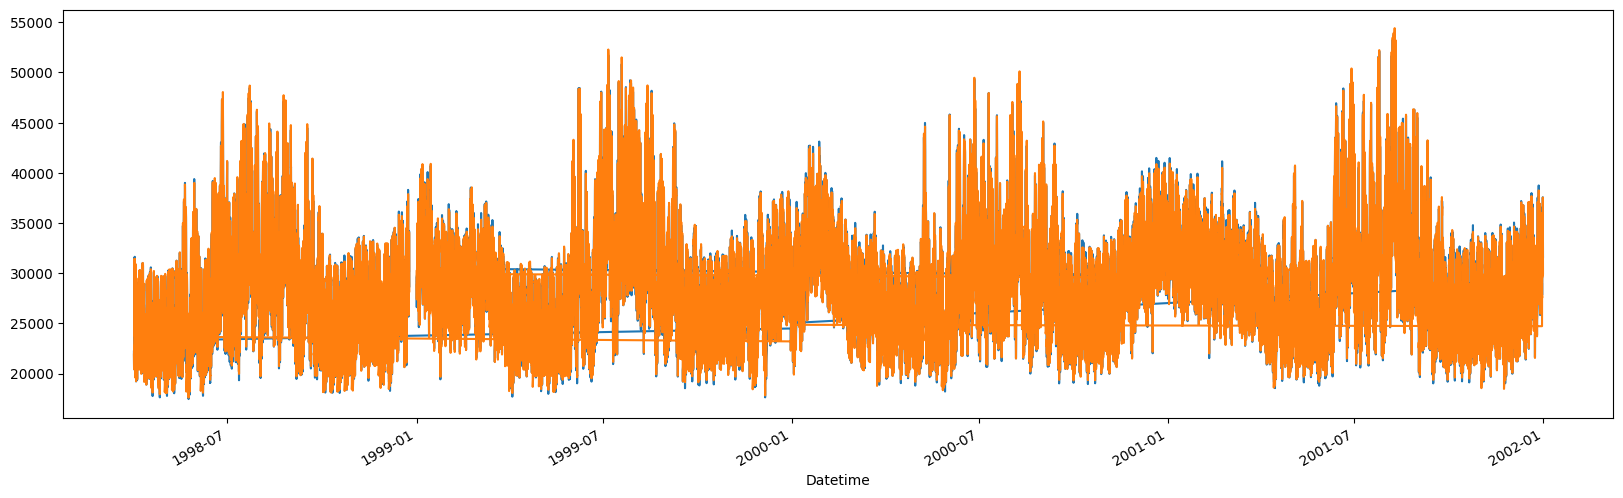

In [32]:
region_data.set_index('Datetime')['Consumption'].plot(figsize=(20,6))
region_data.set_index('Datetime')['Prediction'].plot(figsize=(20,6))

# Conclusion

This project demonstrated a complete time series forecasting workflow — from data exploration and feature engineering to model training and evaluation.  

Key takeaways:
- Exploratory analysis revealed clear **trends, seasonality, and regional differences** in energy consumption.  
- Feature engineering with **lag variables and rolling averages** allowed the models to capture short-term and long-term dependencies.  
- Among the tested models, **Random Forest achieved the best performance**, with:  
  - RMSE ≈ **420.95**  
  - MAPE ≈ **2.66%**  
  - R² ≈ **0.9989**  

These results highlight the strength of ensemble methods in capturing complex consumption patterns, making Random Forest a strong choice for forecasting tasks.  
